# Import Packages and Dataset

## Packages

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from keras.engine.topology import Layer
from keras.engine import InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
import json
import re
import sys
from collections import Counter, OrderedDict

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Input,Activation
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.optimizers import Adam
from keras import regularizers


from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_nostopword_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [6]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis juga bisa menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar tun...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya lanjut olimpi...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi medium sosi...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_nostopword_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [8]:
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,do insult one for be cina kafir make you a goo...
3,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partai partai demokrasi indon...
4,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_nostopword_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [10]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,so much berengsek people in the world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,so how can i get my rekening berengsek rekenin...
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,rt user dasar bajing url
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user karena kecebong tidak akan aku pria lajan...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,rt user tidak ada urus monyet aku break home t...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1)

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1)

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed'],axis=1)

# Size of Vocabulary

In [0]:
vocab_size = 5000

In [13]:
vect = Tokenizer(num_words = vocab_size)
vect.fit_on_texts(X_train)
# vocab_size = len(vect.word_index)+1

print(vocab_size)

5000


In [14]:
vect.index_word.values()

dict_values(['user', 'tidak', 'be', 'dan', 'di', 'the', 'indonesia', 'kamu', 'aku', 'you', 'itu', 'i', 'to', 'a', 'orang', 'presiden', 'and', 'dengan', 'ini', 'sama', 'apa', 'jadi', 'ada', 'of', 'saja', 'sudah', 'fuck', 'kalau', 'jokowi', 'not', 'islam', 'do', 'in', 'on', 'malaysia', 'dari', 'it', 'rt', 'that', 'for', 'bisa', 'juga', 'bangsat', 'untuk', 'dia', 'agama', 'pilih', 'buat', 'partai', 'mau', 'url', 'rakyat', 'cina', 'lagi', 'this', 'ke', 'ganti', 'kita', 'my', 'prabowo', 'komunis', 'asing', 'but', 'tapi', 't', 'shame', 'karena', 'benar', 'have', 'bukan', 'saya', 'memang', 'jangan', 'lie', 'negara', 'kecebong', 'dalam', 'pak', 'anjing', 'seperti', 'banyak', 'kerja', 'so', 'kata', 'banget', 'like', 'akan', 'satu', 'pada', 'kenapa', 'people', 'lebih', 'semua', 'harus', 'your', 'baru', 'bela', 'daerah', 'lihat', 'mereka', 'we', 'they', 'iya', 'me', 'nih', 'kafir', 'say', 'just', 'begitu', 'gubernur', 'atau', 'wakil', 'he', 'sampai', 'all', 'mana', 'adalah', 'salah', 'kepala', 'a

# Modelling Using LSTMs

## Padding and preparing input sequences

In [15]:
encoded_docs_train = vect.texts_to_sequences(X_train)
padded_docs_train = sequence.pad_sequences(encoded_docs_train,maxlen=100,padding='post')
print(padded_docs_train)

[[1022  176    3 ...    0    0    0]
 [ 177   61   42 ...    0    0    0]
 [   1    1   90 ...    0    0    0]
 ...
 [ 855  301  197 ...    0    0    0]
 [ 142   10  252 ...    0    0    0]
 [ 644    9   92 ...    0    0    0]]


In [16]:
encoded_docs_val = vect.texts_to_sequences(X_val)
padded_docs_val = sequence.pad_sequences(encoded_docs_val,maxlen=100,padding='post')
print(padded_docs_val)

[[  83  485  180 ...    0    0    0]
 [  83  229  121 ...    0    0    0]
 [  38    1  160 ...    0    0    0]
 ...
 [   1 1177 1177 ...    0    0    0]
 [   1    1  142 ...    0    0    0]
 [   1    1    1 ...    0    0    0]]


In [17]:
encoded_docs_test = vect.texts_to_sequences(X_test)
padded_docs_test = sequence.pad_sequences(encoded_docs_test,maxlen=100,padding='post')
print(padded_docs_test)

[[1052   64  180 ...    0    0    0]
 [ 421 1098  274 ...    0    0    0]
 [  32 2525  221 ...    0    0    0]
 ...
 [ 762  799   69 ...    0    0    0]
 [   1    1   94 ...    0    0    0]
 [   1  271   71 ...    0    0    0]]


## Defining Model

In [18]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=64))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(AttentionWithContext())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
attention_with_context_1 (At (None, 128)               16640     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 411,724
Trainable params: 411,724
Non-trainable params: 0
_________________________________________________________________


## Training using adam optimizer and binary cross entropy

In [26]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(padded_docs_train, y_train.values, 
                    validation_data=(padded_docs_val, y_val.values),
                    epochs=5, batch_size=256, 
                    verbose=2)

Train on 13244 samples, validate on 1472 samples
Epoch 1/5
 - 6s - loss: 0.1364 - accuracy: 0.9506 - val_loss: 0.3516 - val_accuracy: 0.8838
Epoch 2/5
 - 6s - loss: 0.1228 - accuracy: 0.9566 - val_loss: 0.3555 - val_accuracy: 0.8862
Epoch 3/5
 - 6s - loss: 0.1222 - accuracy: 0.9571 - val_loss: 0.3786 - val_accuracy: 0.8852
Epoch 4/5
 - 6s - loss: 0.1157 - accuracy: 0.9599 - val_loss: 0.3672 - val_accuracy: 0.8834
Epoch 5/5
 - 6s - loss: 0.1099 - accuracy: 0.9620 - val_loss: 0.3804 - val_accuracy: 0.8813


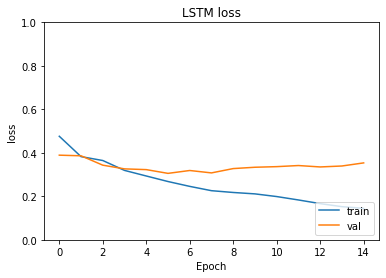

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [0]:
# Final evaluation of the model
scores = model.evaluate(padded_docs_test, y_test.values)

print("Accuracy: %.2f%%" % (scores[1]*100))

115/115 [==============================] - 1s 6ms/step - loss: 0.3570 - accuracy: 0.3209
Accuracy: 32.09%


# Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modelbiLSTM_nostopword.h5')

# Predict and Result

## Predict Data Test

In [0]:
predict = model.predict(padded_docs_test)
predict_train = model.predict(padded_docs_train)
predict_val = model.predict(padded_docs_val)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [29]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test.values,pred_test)
haml_loss = hamming_loss(y_test.values,pred_test)
label_acc = labelSetAccuracy(y_test.values,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.5703804347826087
hamming loss =  0.11274909420289855
label based accuracy =  0.6835720755693583


In [30]:
pred = predict_train.copy()
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
acc = accuracy_score(y_train.values,pred)
haml_loss = hamming_loss(y_train.values,pred)
label_acc = labelSetAccuracy(y_train.values,pred)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.8038356991845363
hamming loss =  0.03451248364039062
label based accuracy =  0.9042920603759473


In [25]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val.values,pred_val)
haml_loss = hamming_loss(y_val.values,pred_val)
label_acc = labelSetAccuracy(y_val.values,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.561141304347826
hamming loss =  0.11775362318840579
label based accuracy =  0.6640358113354037


## Analysis Result

### Data Validation Predict Result Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).join(y_val).reset_index(drop=True)

In [0]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajing url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan aku pria lajan...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urus monyet aku break home t...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=y_val.columns))

In [0]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajing url,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user karena kecebong tidak akan aku pria lajan...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,rt user tidak ada urus monyet aku break home t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

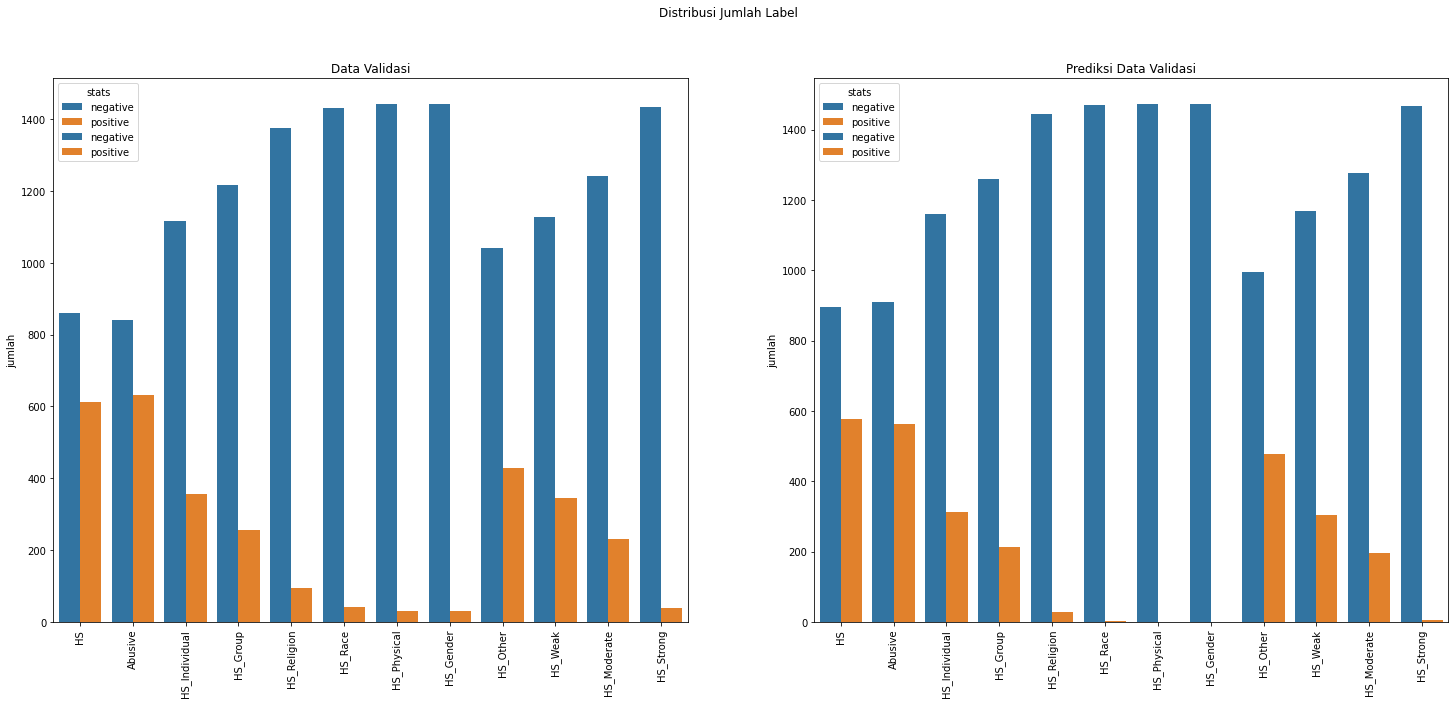

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,896,576
1,Abusive,840,632,909,563
2,HS_Individual,1115,357,1159,313
3,HS_Group,1216,256,1259,213
4,HS_Religion,1376,96,1444,28
5,HS_Race,1431,41,1470,2
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1472,0
8,HS_Other,1042,430,994,478
9,HS_Weak,1128,344,1168,304


#### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
oov_val = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [0]:
oov_val_count

{'': 877,
 'abortion': 1,
 'ache': 1,
 'adele': 1,
 'admirer': 1,
 'advertise': 1,
 'aese': 1,
 'afford': 1,
 'afterwards': 1,
 'akil': 1,
 'aksinesia': 1,
 'aktris': 1,
 'alia': 1,
 'ancient': 1,
 'apki': 1,
 'apko': 1,
 'apostate': 1,
 'arifinto': 1,
 'arrogance': 1,
 'au': 1,
 'aur': 1,
 'backpass': 2,
 'barakat': 1,
 'behead': 1,
 'belaganya': 1,
 'bengkok': 1,
 'berlusconi': 1,
 'bimas': 1,
 'bish': 1,
 'bjp': 3,
 'budhis': 1,
 'buntel': 1,
 'carbondioxide': 1,
 'carrier': 1,
 'cashflow': 1,
 'cetar': 2,
 'chief': 1,
 'cingkrang': 1,
 'civilization': 1,
 'coach': 1,
 'coexist': 1,
 'coin': 1,
 'colonel': 1,
 'colonise': 1,
 'coloniser': 1,
 'comunis': 1,
 'contribute': 1,
 'coverage': 1,
 'cynical': 1,
 'daesung': 1,
 'determine': 1,
 'devastate': 1,
 'didi': 1,
 'dihadang': 1,
 'dino': 1,
 'ditho': 1,
 'diz': 1,
 'dramatically': 1,
 'dusuki': 1,
 'edgy': 1,
 'effective': 1,
 'ekspat': 1,
 'enong': 1,
 'envelope': 1,
 'escpecially': 1,
 'exhaust': 1,
 'expel': 1,
 'extinguish': 1,

In [0]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  1164
number of unique OOV words :  278


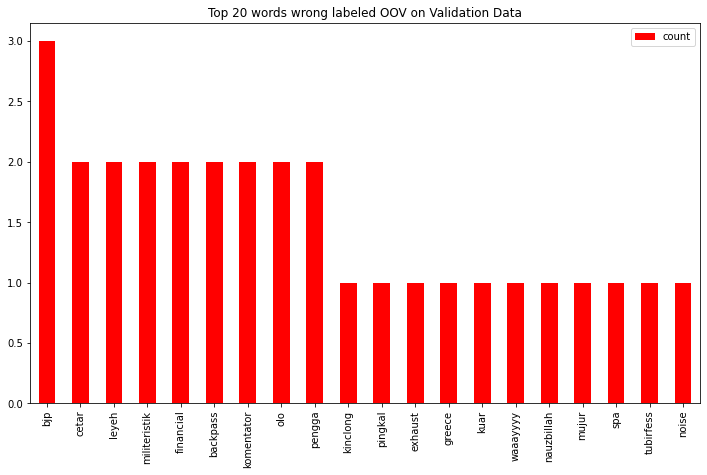

In [0]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

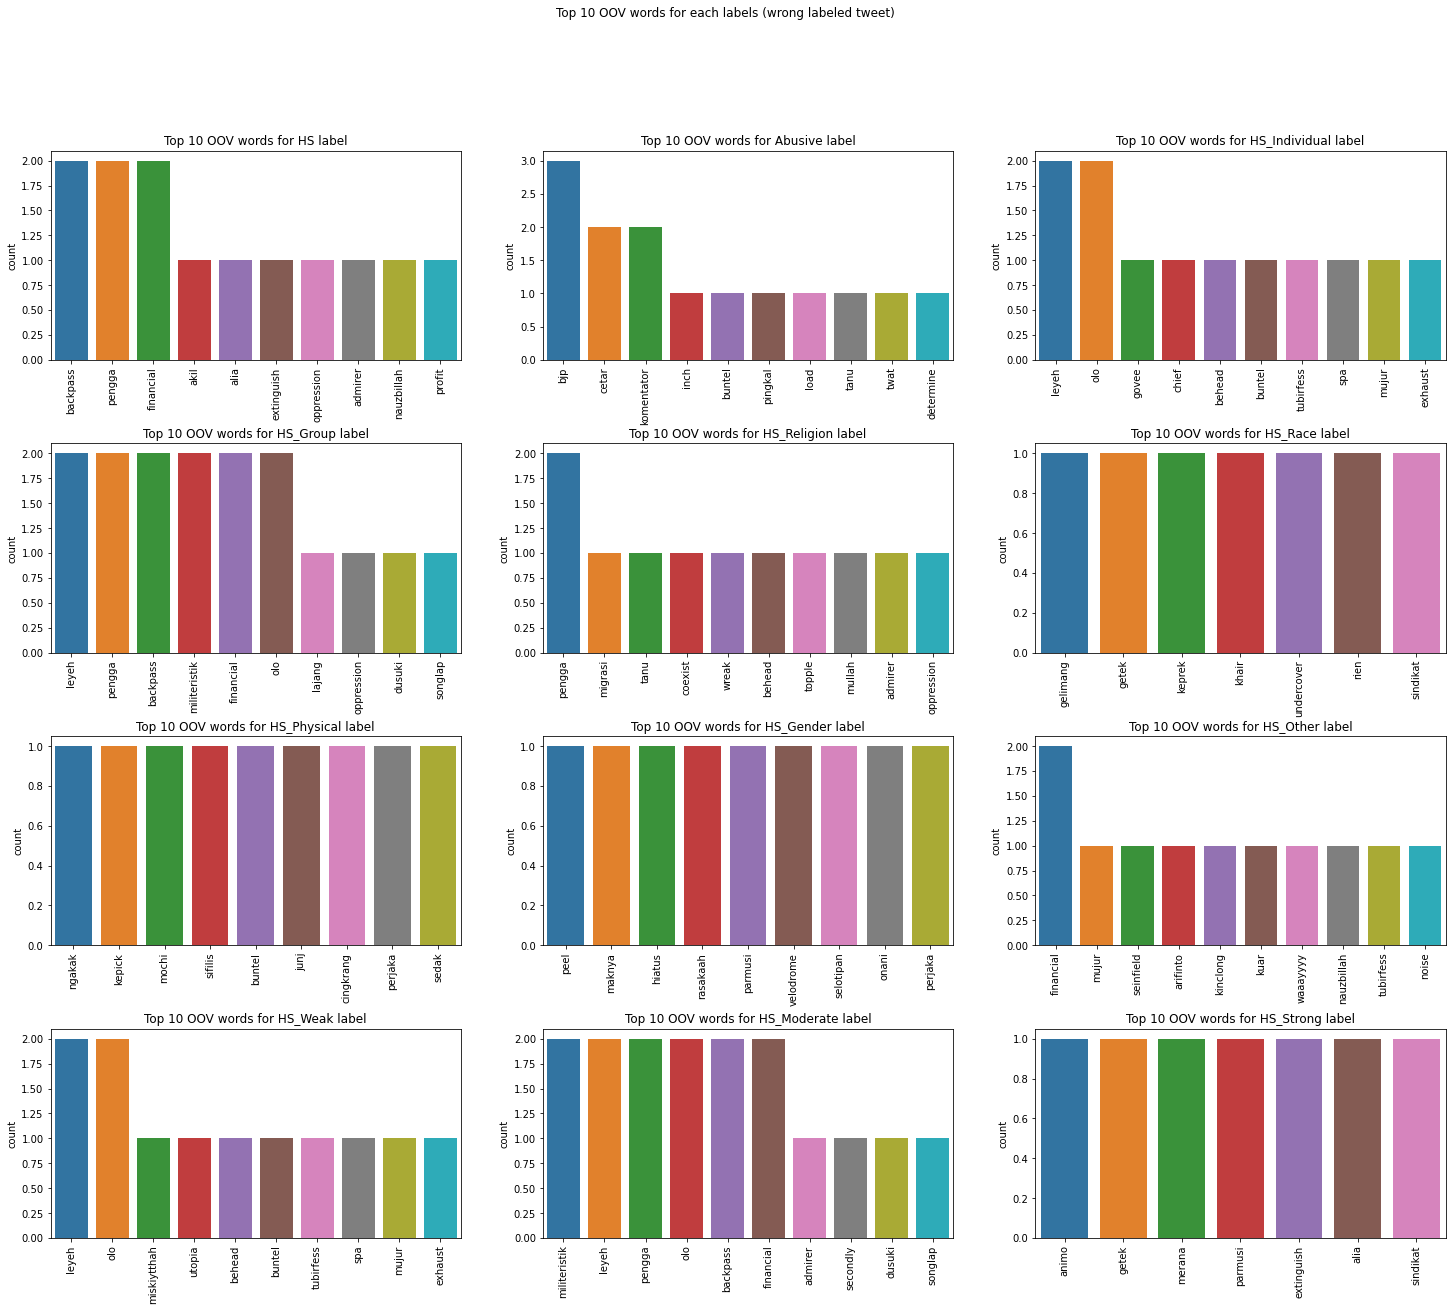

In [0]:
target = y_val.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajing url',
 'user karena kecebong tidak akan aku pria lajang  cuma lulu  sastra bagai profesor karena untuk sebut profesor anak sampai  tau harus lalu stratum didik lagi telah  itu jawab an kenapa kecebong lebih cerdas dari ban kampret ',
 'rt user tidak ada urus monyet aku break home tidak begitu begitu amat malah pukul sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'rt user  tai  tidak ada  mau join tag close agency basic ',
 'user user aku lagi celeng tidak buat synna emosi jangan mancing  ',
 'user user bacot  kalian ',
 'bahas islam rusak nilai user kuat karakter lalu revitalisasi didik nilai',
 'user kamu kafir banci   ampun sudah kafir banci lagi jangan sedih  cong kamu google  kafir banci kayak kamu ',
 'user mau naik apa seperti bodoh amat tidak pengaruh keleees lihat poll google minta presiden  ganti apa apa apa ganti presiden pak ogah ganti presiden',
 'sendu gila rasa ',
 'user ingat partai demokrasi ind

In [0]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
miss_exact_tweet_val.iloc[:,1:-12].values.tolist()

[[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1,

In [0]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

### Data Test Predict Result Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=y_test.columns)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

#### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[1:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[1:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[1:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

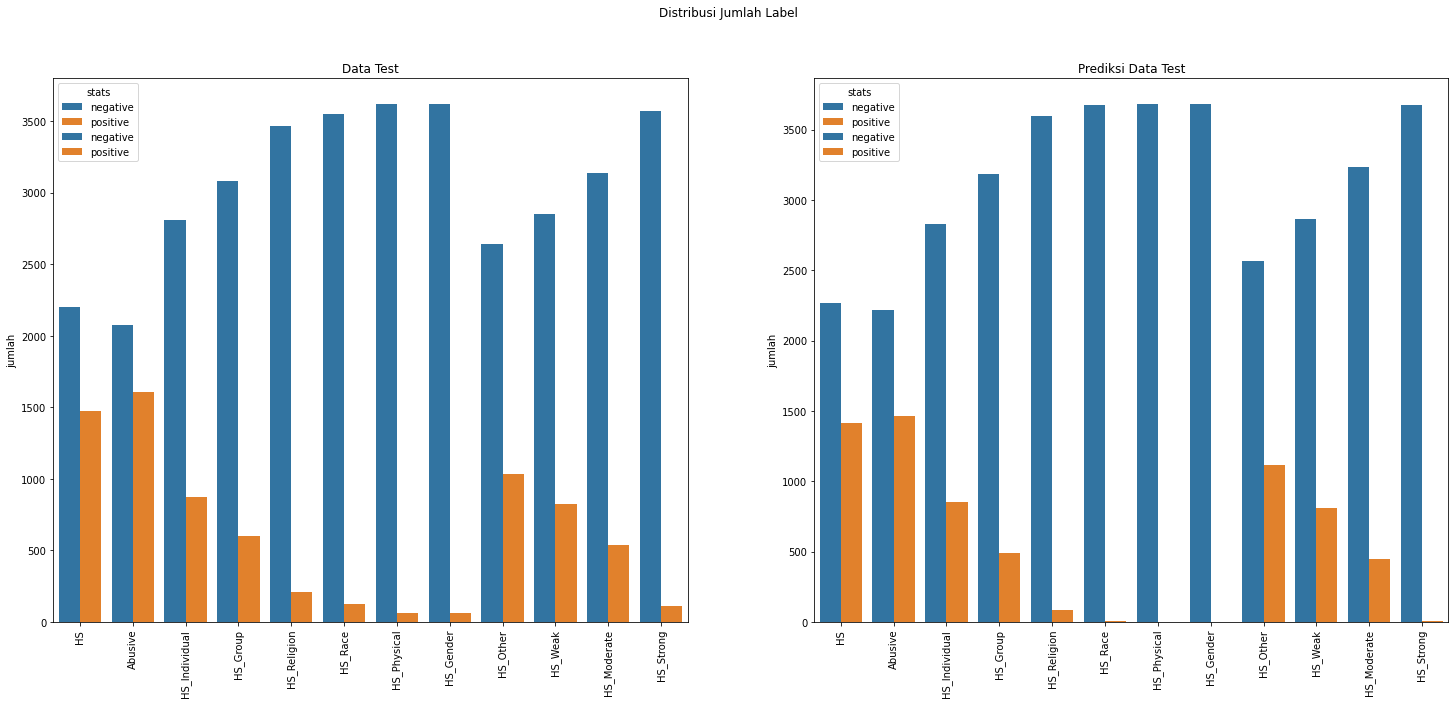

In [0]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [0]:
pd.DataFrame({
    "label" : data_test.columns[1:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2266,1414
1,Abusive,2075,1605,2216,1464
2,HS_Individual,2806,874,2826,854
3,HS_Group,3078,602,3187,493
4,HS_Religion,3467,213,3597,83
5,HS_Race,3551,129,3674,6
6,HS_Physical,3617,63,3680,0
7,HS_Gender,3616,64,3680,0
8,HS_Other,2643,1037,2566,1114
9,HS_Weak,2854,826,2867,813


#### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak_predict"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate_predict"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong_predict"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vect.index_word.values(), generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [0]:
oov_test_count

{'': 2122,
 'aaaaaaaaaaaaaaa': 1,
 'abur': 1,
 'activate': 1,
 'administrative': 1,
 'adora': 1,
 'afai': 1,
 'afganistan': 1,
 'afno': 1,
 'afterall': 1,
 'agate': 1,
 'agel': 1,
 'agnesmo': 1,
 'airplane': 1,
 'akademisi': 1,
 'alienate': 1,
 'alina': 1,
 'allegiance': 1,
 'alonso': 1,
 'alpha': 1,
 'alucard': 1,
 'anjiiirr': 1,
 'anon': 1,
 'ante': 1,
 'apocalypse': 1,
 'appeal': 2,
 'appologise': 1,
 'appologize': 1,
 'apprently': 1,
 'ardhog': 1,
 'arra': 1,
 'ascend': 1,
 'ashraf': 1,
 'atip': 1,
 'atmosphere': 1,
 'authentic': 1,
 'authenticate': 1,
 'auti': 2,
 'avert': 1,
 'babang': 1,
 'bachtiar': 1,
 'backward': 1,
 'badik': 1,
 'bagak': 1,
 'bagdadi': 1,
 'baja': 1,
 'bajigur': 1,
 'bajul': 1,
 'bakery': 1,
 'bald': 1,
 'balur': 2,
 'bantat': 1,
 'barkley': 1,
 'bat': 1,
 'batch': 1,
 'bati': 1,
 'becky': 2,
 'beer': 1,
 'behold': 1,
 'beholder': 1,
 'belia': 1,
 'bell': 1,
 'benalu': 1,
 'benih': 1,
 'berang': 1,
 'berkotey': 1,
 'berswafoto': 1,
 'bersyariah': 1,
 'besand

In [0]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  3003
number of unique OOV words :  799


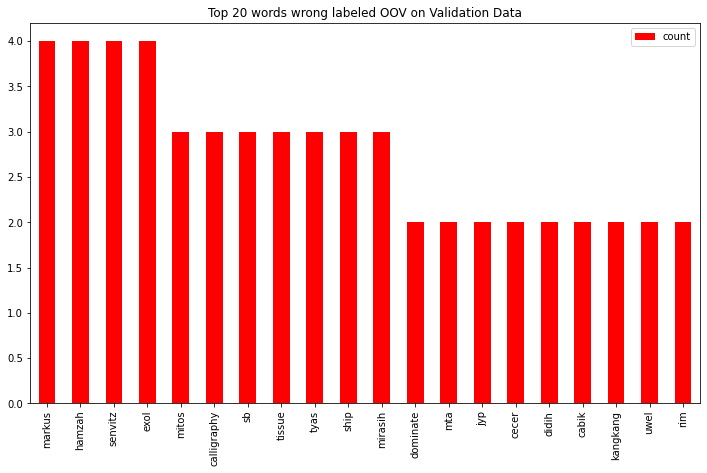

In [0]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

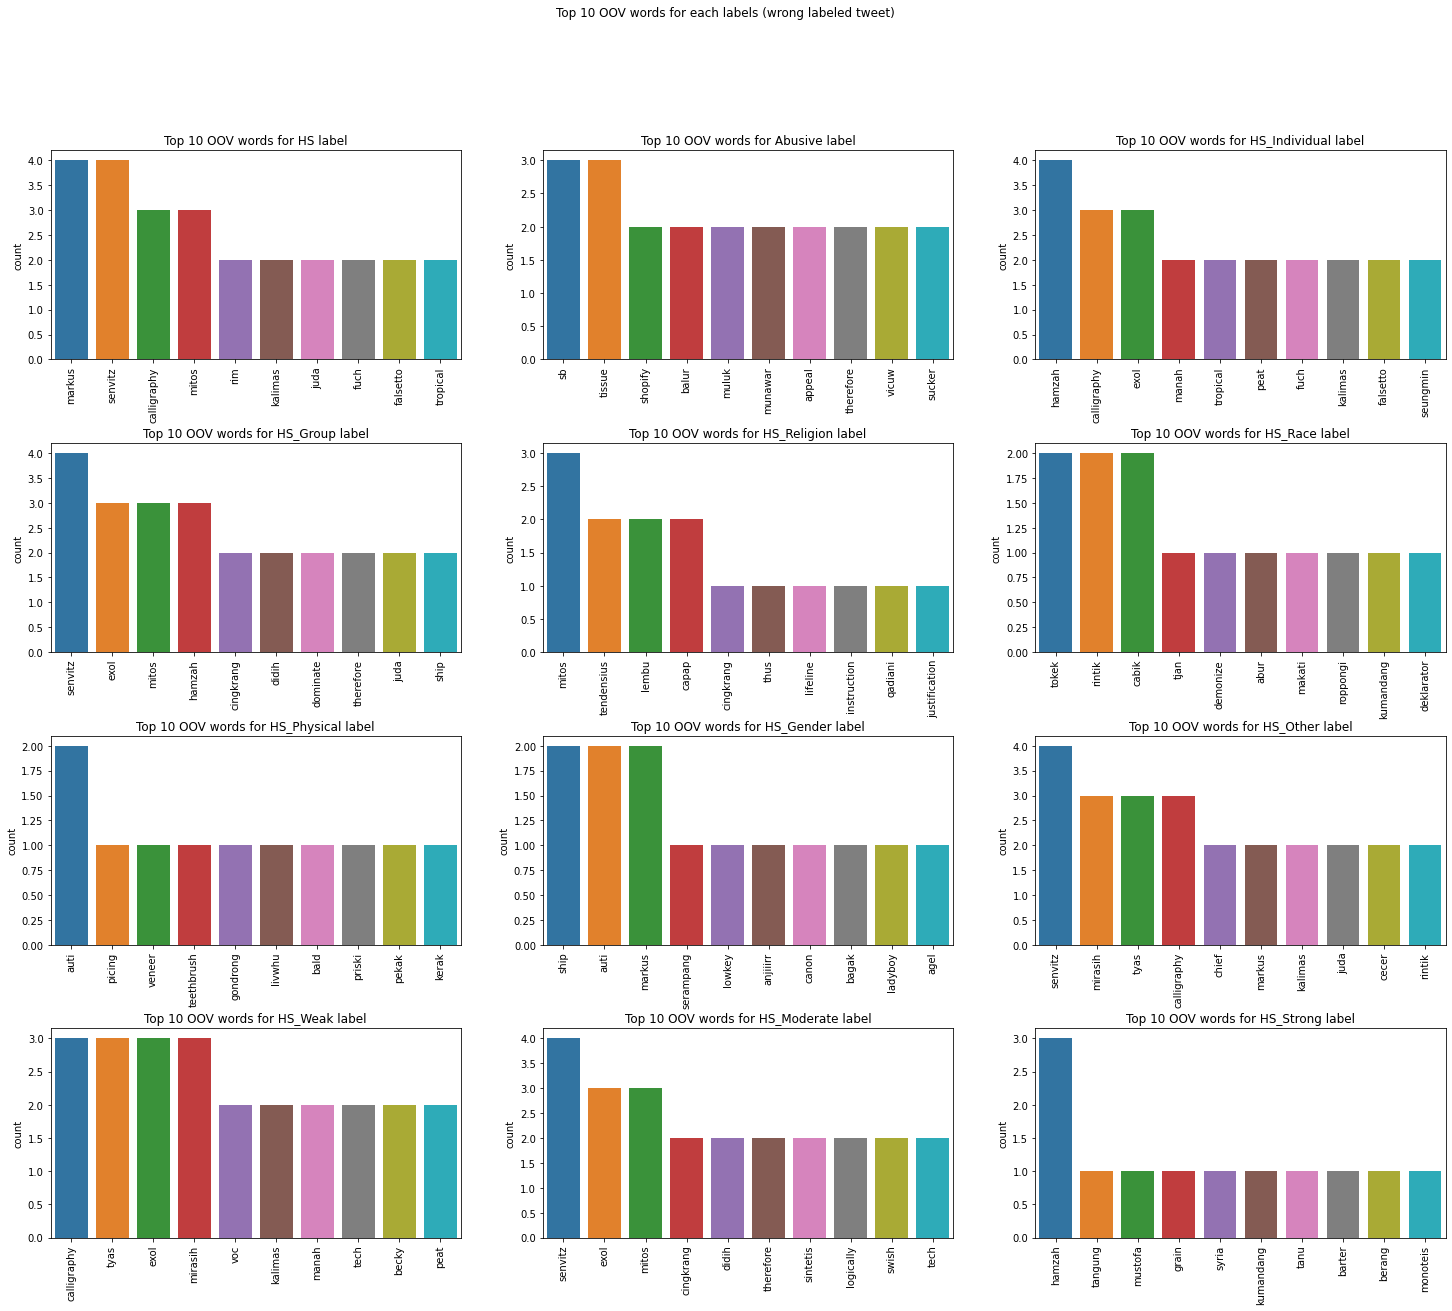

In [0]:
target = y_test.columns

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vect.index_word.values(), wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

#### Tweet Check

In [0]:
miss_exact_tweet_test['Tweet'].values.tolist()

['Does insulting one for being "Cina", "Kafir", make you a better Muslim?',
 "USER Khan yg ngajarin si garong kafir'",
 'i might say "kontol" more often because its im in need of......',
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "Hamdalah. Kelar juga ini fitur keparat.'",
 "USER Jancuk! Pingin gue tabok itu anak'",
 'I like you. You like him, itukan berengsek :3 #nyampah',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di jawab apa. Kena skak mat d pertanyaan isu agama tdi. Dasar cina tolol hahaha',
 "USER Astagaaa.. Sewa pecun skalian ga pak?'",
 'Pantes idiot makananya upil URL',
 'When you cheat and "win" you\'ve distinguished yourself as a LOSER!  #ShameOnYouMalaysia #SEAGames2017',
 "I ever since 2016 came to work early and finished work late and work my ass off this

In [0]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['do insult one for be cina kafir make you a good muslim ',
 'user   ajar  garong kafir ',
 'i might say kontol more often because it be i be in need of ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user sudah siap di demo jilid jilid sama ban cingkrang malaysia laku syariat islam tapi legal judi dengan bagai syarat dan tentu  strict ',
 'hamdalah selesai juga ini fitur keparat ',
 'user jancuk ingin aku tabok itu anak ',
 'i like you you like him itu  berengsek sampah',
 ' mata najwa debat jakarta lucu banget jawab ahok tidak sambung tanya apa di jawab apa kena sekak mat di tanya isu agama tadi dasar cina tolol ',
 'user astaga sewa pecun sekali tidak pak ',
 'pantas idiot makan upil url',
 'when you cheat and menang you ve distinguish yourself a a loser shame on you malaysia sea game ',
 'i ever sejak come to work early and finish work late and work my as off this kindergarten even though i be not feel well but my bos say i need to improve my work skill apa you want me to

In [0]:
miss_exact_tweet_test.iloc[:,1:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [0]:
# real label
miss_exact_tweet_test.iloc[:,1:-13].values.tolist()

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_test.iloc[:,-12:].values.tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0